In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import yaml
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy

In [23]:
os.chdir('/data/rsg/nlp/sdobers/amine/diffdock-protein/src')

from args import parse_args
from data import load_data, get_data
from data.data import BindingDataset
from model import load_model, to_cuda
from utils import printt, print_res, log, get_unixtime, compute_rmsd
from train import train, evaluate, evaluate_pose
from helpers import WandbLogger, TensorboardLogger
from sample import sample

In [24]:
CUDA_VISIBLE_DEVICE = 1
torch.cuda.set_device(CUDA_VISIBLE_DEVICE)
print(torch.cuda.is_available())

True


In [25]:
PATH = '/data/rsg/nlp/sdobers/amine/diffdock-protein/ckpts/dips_medium_model/'

In [26]:
class Dict2Class:
    def __init__(self, my_dict):
        for key in my_dict:
            setattr(self, key, my_dict[key])

In [27]:
# load args
with open(os.path.join(PATH, 'args.yaml')) as f:
    args = yaml.safe_load(f)
args['num_gpu'] = 1
args['gpu'] = CUDA_VISIBLE_DEVICE
args = Dict2Class(args)
args.data_file = args.data_file.replace('data_file', 'data_file_only_val')

In [28]:
args.data_file

'/data/rsg/nlp/sdobers/data/DIPS/data_file_only_val.csv'

In [29]:
# load raw data
data = load_data(args)
data_params = data.data_params

data loading: 100%|█| 985/985 [00:00<00:00, 785285


14:25:57 Loaded cached ESM embeddings
14:25:57 finished tokenizing residues with ESM
14:25:57 finished tokenizing all inputs
14:25:57 985 entries loaded


In [30]:
val_dataset = BindingDataset(args, data.data)

In [31]:
len(val_dataset)

985

In [12]:
args.checkpoint_path = PATH

In [13]:
# get model and load checkpoint, if relevant
model = load_model(args, data_params, 0)
model = to_cuda(model, args)

/data/rsg/nlp/sdobers/miniconda3/envs/diffdock_protein/lib/python3.10/site-packages/torch/jit/_check.py:181: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


12:41:43 loaded model with kwargs: 
12:41:43 loaded checkpoint from /data/rsg/nlp/sdobers/amine/diffdock-protein/ckpts/dips_medium_model/fold_0/model_best_113385_90_0.498_0.498.pth


In [14]:
val_dataset_without_noise = copy.deepcopy(val_dataset)
val_dataset_without_noise.transform = None
len(val_dataset_without_noise)

985

In [15]:
n_runs = 10
rmsds = np.full(len(val_dataset), np.inf)
for i in range(n_runs):
    print(f'----------------- in iteration {i} -----------------')
    # run reverse diffusion process
    samples_val = sample(val_dataset, model, args)
    # samples_val now contains all the graphs, with graph["ligand"] contains the positions predicted by the model
    val_score = evaluate_pose(val_dataset_without_noise, samples_val)
    rmsds_i = np.array(val_score["rmsd"])
    print(f'in iteration {i}: mean is {rmsds_i.mean()}')
    rmsds = np.minimum(rmsds, rmsds_i)
    print(f'in iteration {i}: mean with confidence model is {rmsds.mean()}')
print(f'Final result: {rmsds.mean()}')

----------------- in iteration 0 -----------------
12:48:55 Completed 0 out of 20 steps
12:51:07 Completed 1 out of 20 steps
12:53:05 Completed 2 out of 20 steps
12:54:45 Completed 3 out of 20 steps
12:56:05 Completed 4 out of 20 steps
12:57:07 Completed 5 out of 20 steps
12:57:56 Completed 6 out of 20 steps
12:58:35 Completed 7 out of 20 steps
12:59:07 Completed 8 out of 20 steps
12:59:34 Completed 9 out of 20 steps
12:59:57 Completed 10 out of 20 steps
13:00:19 Completed 11 out of 20 steps
13:00:39 Completed 12 out of 20 steps
13:00:58 Completed 13 out of 20 steps
13:01:16 Completed 14 out of 20 steps
13:01:35 Completed 15 out of 20 steps
13:01:52 Completed 16 out of 20 steps
13:02:09 Completed 17 out of 20 steps
13:02:26 Completed 18 out of 20 steps
13:02:43 Completed 19 out of 20 steps
in iteration 0: mean is 31.420320510864258
in iteration 0: mean with confidence model is 31.42032055013676
----------------- in iteration 1 -----------------
13:05:22 Completed 0 out of 20 steps
13:0

15:15:25 Completed 0 out of 20 steps
15:17:35 Completed 1 out of 20 steps
15:19:30 Completed 2 out of 20 steps
15:21:07 Completed 3 out of 20 steps
15:22:24 Completed 4 out of 20 steps
15:23:26 Completed 5 out of 20 steps
15:24:15 Completed 6 out of 20 steps
15:24:53 Completed 7 out of 20 steps
15:25:24 Completed 8 out of 20 steps
15:25:51 Completed 9 out of 20 steps
15:26:15 Completed 10 out of 20 steps
15:26:37 Completed 11 out of 20 steps
15:26:57 Completed 12 out of 20 steps
15:27:16 Completed 13 out of 20 steps
15:27:35 Completed 14 out of 20 steps
15:27:53 Completed 15 out of 20 steps
15:28:10 Completed 16 out of 20 steps
15:28:27 Completed 17 out of 20 steps
15:28:44 Completed 18 out of 20 steps
15:29:01 Completed 19 out of 20 steps
in iteration 9: mean is 30.597549438476562
in iteration 9: mean with confidence model is 11.945742657826031
Final result: 11.945742657826031


In [16]:
reverse_diffusion_metrics = {'rmsds_lt2': (100 * (rmsds < 2).sum() / len(rmsds)),
                             'rmsds_lt5': (100 * (rmsds < 5).sum() / len(rmsds)),
                             'rmsds_mean': rmsds.mean(),
                             'rmsds_median': np.median(rmsds)}
print('Final results with simulated confidence model:')
print(reverse_diffusion_metrics)

Final results with simulated confidence model:
{'rmsds_lt2': 8.730964467005077, 'rmsds_lt5': 42.63959390862944, 'rmsds_mean': 11.945742657826031, 'rmsds_median': 6.3039631843566895}


In [17]:
print(rmsds)

[48.21757507  3.37800407 44.21419907  2.90468454 32.55943298 34.90921783
 48.18783951  7.97292233  8.19041824 28.32667542 33.35161591 10.24024773
  3.74530268 35.27239609  3.15285134 44.42721176 44.25357819  2.51939726
  7.3604598   2.47298288  7.65314913  4.37582397  7.99440956  2.24190974
  4.55203962  5.31402159  4.34555578 70.42383575 13.38469315  3.88944912
  6.07124615 13.41576195 17.39028549  4.32042265 25.04493904  2.47483325
 14.2322979  43.91702271  5.35801935 35.80218506  1.59601581 15.69939137
  6.98210955  3.25906062  7.81269693  2.96959829 18.87802696  0.80250078
 43.69078064 25.22327042 45.88204956 37.32759476  3.22505212 33.27475739
  5.92184496  2.13747573  7.48031902 44.35893631 28.19549942 11.99171734
 24.92166901 28.75427055 36.66598892  5.0576601   2.44337749 40.51395798
 15.97886944  2.19640684 13.50001144 42.77931595 46.09142303 12.78296661
 25.41015434  2.81477499 31.20156288 41.00351715  9.02551079 17.02858925
  1.54600358  3.12461472  4.1871953   2.89883423 30

In [20]:
rmsds.max()

70.42383575439453

In [ ]:
true_graph, pred_graph = val_dataset_without_noise[rmsds.argmin()], samples_val[rmsds.argmin()]
true_xyz = true_graph["ligand"].pos
pred_xyz = pred_graph["ligand"].pos

print(compute_rmsd(true_xyz, pred_xyz))

#dist_from_com = torch.norm(true_xyz-true_xyz.mean(0), p=2, dim=1)
dist_from_com = torch.norm(pred_xyz-pred_xyz.mean(0), p=2, dim=1)


square_deviation_per_residue = ((true_xyz-pred_xyz)**2).sum(-1)
plt.scatter(dist_from_com, square_deviation_per_residue, s=5)
plt.show()


In [56]:
num_residues = []
average_dist_from_com = []
max_dist_from_com = []
std_dist_from_com = []
sum_dist_from_com = []
for true_graph, pred_graph in tqdm(zip(val_dataset_without_noise, samples_val)):
    
    true_xyz = true_graph["ligand"].pos
    pred_xyz = pred_graph["ligand"].pos
    
    num_residues.append(true_xyz.shape[0])
    
    dist_from_com = torch.norm(true_xyz-true_xyz.mean(0), p=2, dim=1)
    average_dist_from_com.append(dist_from_com.mean())
    max_dist_from_com.append(dist_from_com.max())
    std_dist_from_com.append(dist_from_com.std())
    sum_dist_from_com.append(dist_from_com.sum())
    
    #dist_from_com_pred = torch.norm(pred_xyz-pred_xyz.mean(0), p=2, dim=1)
    #print(f'MEAN. true: {dist_from_com.mean()}. pred: {dist_from_com_pred.mean()}')
    #print(f'MAX. true: {dist_from_com.max()}. pred: {dist_from_com_pred.max()}')
    
    #square_deviation_per_residue = ((true_xyz-pred_xyz)**2).sum(-1)
    #plt.scatter(dist_from_com, square_deviation_per_residue, s=5)
    #plt.show()
    #print(true_xyz.shape)
    #print(pred_xyz.shape)
    #break
num_residues = np.array(num_residues)
average_dist_from_com = np.array(average_dist_from_com)
max_dist_from_com = np.array(max_dist_from_com)
std_dist_from_com = np.array(std_dist_from_com)
sum_dist_from_com = np.array(sum_dist_from_com)
print(num_residues.shape)
print(average_dist_from_com.shape)
print(max_dist_from_com.shape)
print(std_dist_from_com.shape)
print(sum_dist_from_com.shape)

985it [00:00, 1442.29it/s]


(985,)
(985,)
(985,)
(985,)
(985,)


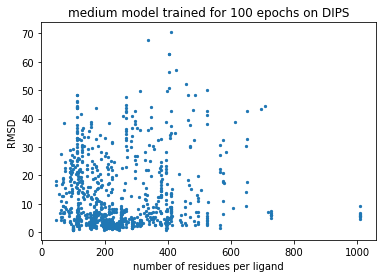

In [36]:
plt.scatter(num_residues, rmsds, s=5)
plt.title("medium model trained for 100 epochs on DIPS")
plt.xlabel("number of residues per ligand")
plt.ylabel("RMSD")
plt.show()

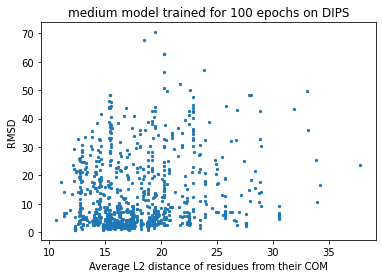

In [38]:
plt.scatter(average_dist_from_com, rmsds, s=5)
plt.title("medium model trained for 100 epochs on DIPS")
plt.xlabel("Average L2 distance of residues from their COM")
plt.ylabel("RMSD")
plt.show()

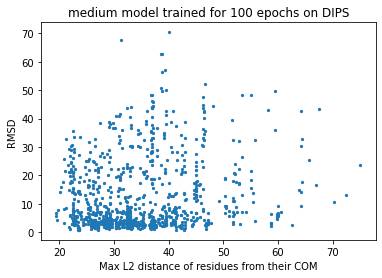

In [39]:
plt.scatter(max_dist_from_com, rmsds, s=5)
plt.title("medium model trained for 100 epochs on DIPS")
plt.xlabel("Max L2 distance of residues from their COM")
plt.ylabel("RMSD")
plt.show()

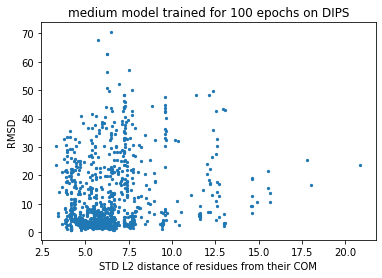

In [55]:
plt.scatter(std_dist_from_com, rmsds, s=5)
plt.title("medium model trained for 100 epochs on DIPS")
plt.xlabel("STD L2 distance of residues from their COM")
plt.ylabel("RMSD")
plt.show()

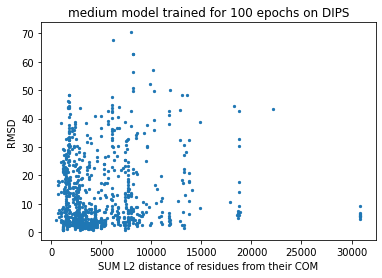

In [57]:
plt.scatter(sum_dist_from_com, rmsds, s=5)
plt.title("medium model trained for 100 epochs on DIPS")
plt.xlabel("SUM L2 distance of residues from their COM")
plt.ylabel("RMSD")
plt.show()

In [42]:
from torch_geometric.loader import DataLoader^

[autoreload of sample failed: Traceback (most recent call last):
  File "/data/rsg/nlp/sdobers/miniconda3/envs/diffdock_protein/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/data/rsg/nlp/sdobers/miniconda3/envs/diffdock_protein/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/data/rsg/nlp/sdobers/miniconda3/envs/diffdock_protein/lib/python3.10/importlib/__init__.py", line 168, in reload
    raise ModuleNotFoundError(f"spec not found for the module {name!r}", name=name)
ModuleNotFoundError: spec not found for the module 'sample'
]


In [44]:
test_loader = DataLoader(val_loader, batch_size=args.batch_size)

In [54]:
for complex_graphs in test_loader:
    complex_graphs = complex_graphs.cuda()
    print(complex_graphs["ligand"]['node_t']['tr'].device)
    break

cuda:1
